**временные ряды и модели ARIMA**

Евгений Борисов <esborisov@sevsu.ru>

-----

Дмитрий Макаров   Временные ряды.    
https://www.dmitrymakarov.ru/intro/time-series-20/

Евгений Рябенко Прогнозирование временных рядов.     
https://www.youtube.com/watch?v=u433nrxdf5k

-----

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt
import pandas as pd
#from tqdm.auto import tqdm
#tqdm.pandas()
np.set_printoptions(precision=2)

---

AirPassengers.csv

https://drive.google.com/file/d/1yfw6gcgmJXCtxkjC69ekUvsEtAiYTlST/view?usp=share_link

https://huggingface.co/spaces/Anniek/Time_series_forecast/raw/main/AirPassengers.csv

In [2]:
# читаем данные
url = 'https://huggingface.co/spaces/Anniek/Time_series_forecast/raw/main/AirPassengers.csv'
df = pd.read_csv(url).convert_dtypes()
display(len(df))
display(df.info())
display(df.describe().T)

144

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    string
 1   #Passengers  144 non-null    Int64 
dtypes: Int64(1), string(1)
memory usage: 2.5 KB


None

,count,mean,std,min,25%,50%,75%,max
#Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [3]:
df['dt'] = pd.to_datetime(df['Month'])
df = df.set_index('dt')
df = df[['#Passengers']]

display(df.sample(3))

,#Passengers
dt,
1952-05-01,183
1953-12-01,201
1955-01-01,242


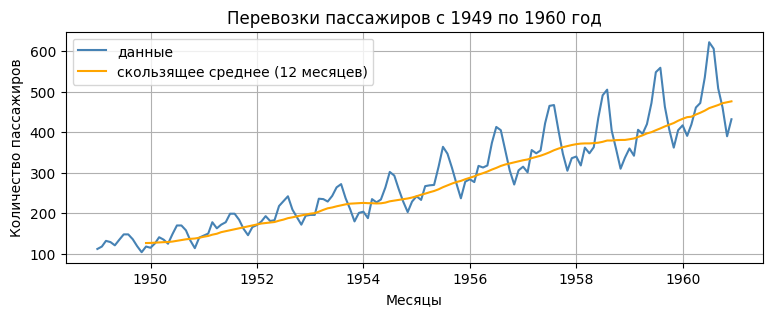

In [4]:
fig,ax = plt.subplots(figsize = (9,3))
ax.plot(df['#Passengers'], label = 'данные', color = 'steelblue')
ax.plot(df['#Passengers'].rolling(window=12).mean(), label = 'скользящее среднее (12 месяцев)', color = 'orange')
ax.set_xlabel('Месяцы', )
ax.set_ylabel('Количество пассажиров',)
ax.set_title('Перевозки пассажиров с 1949 по 1960 год', )
ax.legend(title = '', loc = 'upper left', )
ax.grid()

# анализ данных

__Автокорреляция__

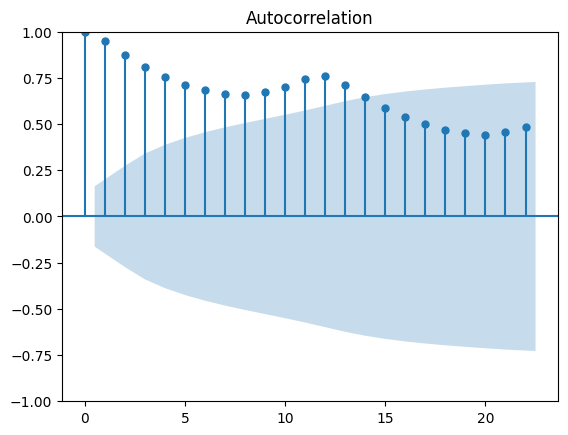

In [5]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['#Passengers'])
plt.show()

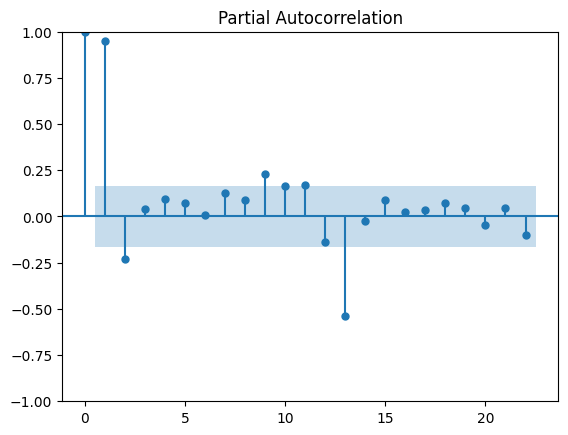

In [128]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['#Passengers'])
plt.show()

__Проверка временного ряда на стационарность__

In [6]:
# тест Дики-Фуллера (Dickey-Fuller test)

from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df['#Passengers'])

print('p-value = ' + str(adf_test[1]))

p-value = 0.991880243437641


__стабилизация дисперсии__

In [7]:
from scipy.special import boxcox, inv_boxcox

df['bc'] = boxcox( df['#Passengers'],0 )
df['bc_inv'] = inv_boxcox(df['bc'],0)

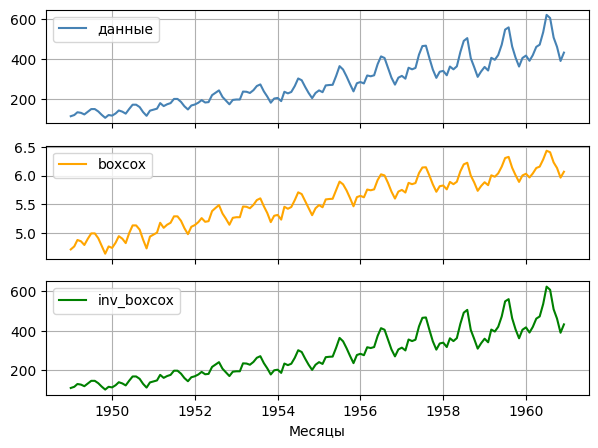

In [8]:
fig,ax = plt.subplots(3,1, figsize = (7,5),sharex=True)
ax[0].plot(df['#Passengers'], label = 'данные', color = 'steelblue')
ax[0].legend(title = '', loc = 'upper left', )
ax[0].grid()

ax[1].plot(df['bc'], label = 'boxcox', color = 'orange')
ax[1].legend(title = '', loc = 'upper left', )
ax[1].grid()

ax[2].plot(df['bc_inv'], label = 'inv_boxcox', color = 'green')
ax[2].set_xlabel('Месяцы', )
ax[2].legend(title = '', loc = 'upper left', )
ax[2].grid()

__убираем тренды__

In [99]:
df['dif1'] = df['bc'].diff()
df['dif2'] = df['bc'].diff(2)

In [100]:
# проверка на стационарность
from statsmodels.tsa.stattools import adfuller
adf_test_0 = adfuller(df['#Passengers'])
adf_test_1 = adfuller(df['dif1'].fillna(0.))
adf_test_2 = adfuller(df['dif2'].fillna(0.))

print('p-value orig = ' + str(adf_test_0[1]))
print('p-value bcx+dif = ' + str(adf_test_1[1]))
print('p-value bcx+dif+dif = ' + str(adf_test_2[1]))

p-value orig = 0.991880243437641
p-value bcx+dif = 0.07859381719564043
p-value bcx+dif+dif = 0.008521204852369969


In [101]:
# обратное дифференцированию преобразование
y = [ df['bc'].iloc[0] ] 
for d in df['dif1'].iloc[1:]: y.append(y[-1]+d)
df['dif1_inv'] = y

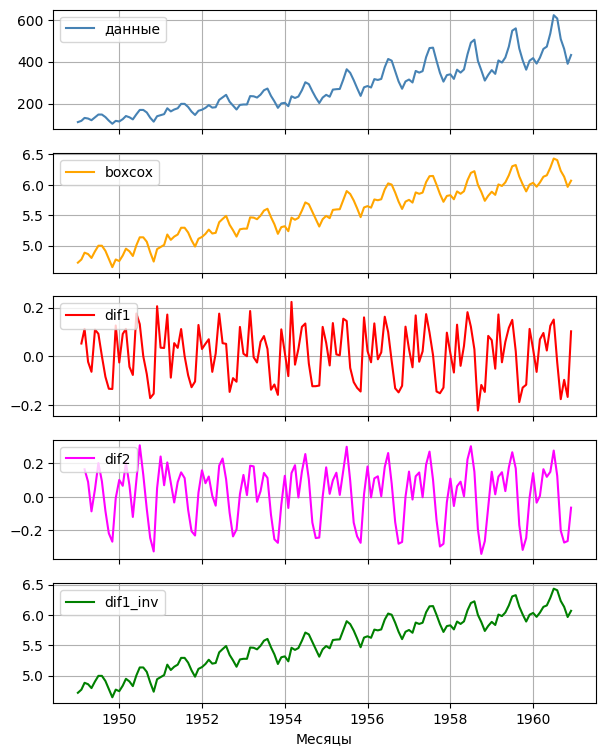

In [104]:
fig,ax = plt.subplots(5,1, figsize = (7,9),sharex=True)
ax[0].plot(df['#Passengers'], label = 'данные', color = 'steelblue')
ax[0].legend(title = '', loc = 'upper left', )
ax[0].grid()

ax[1].plot(df['bc'], label = 'boxcox', color = 'orange')
ax[1].legend(title = '', loc = 'upper left', )
ax[1].grid()

ax[2].plot(df['dif1'], label = 'dif1', color = 'red')
ax[2].legend(title = '', loc = 'upper left', )
ax[2].grid()

ax[3].plot(df['dif2'], label = 'dif2', color = 'magenta')
ax[3].legend(title = '', loc = 'upper left', )
ax[3].grid()

ax[4].plot(df['dif1_inv'], label = 'dif1_inv', color = 'green')
ax[4].set_xlabel('Месяцы', )
ax[4].legend(title = '', loc = 'upper left', )
ax[4].grid()

---

In [105]:
# !pip install statsmodels

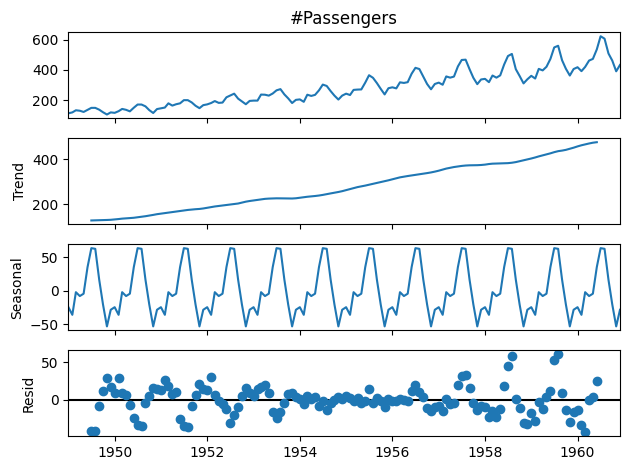

In [106]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(df['#Passengers'])
decompose.plot()
plt.show()

# модель

## простая регрессия

In [107]:
from sklearn.preprocessing import PolynomialFeatures

degree = 9

y = df['#Passengers'].values

x =  PolynomialFeatures( 
        degree=degree, 
        interaction_only=False, 
        include_bias=True,
    ).fit_transform( np.arange(len(y)).reshape(-1,1) )

In [108]:
from sklearn.linear_model import LinearRegression
    
df['regr']  = LinearRegression().fit(x,y).predict(x)

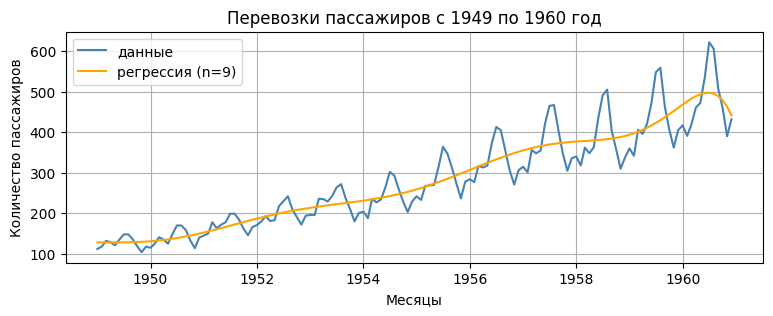

In [110]:
fig,ax = plt.subplots(figsize = (9,3))
ax.plot(df['#Passengers'], label = 'данные', color = 'steelblue')
ax.plot(df['regr'], label = f'регрессия (n={degree})', color = 'orange')
ax.set_xlabel('Месяцы', )
ax.set_ylabel('Количество пассажиров',)
ax.set_title('Перевозки пассажиров с 1949 по 1960 год', )
ax.legend(title = '', loc = 'upper left', )
ax.grid()

## модель ARIMA

In [111]:
# разобьём данные на обучающую и тестовую выборки

# обучающая выборка будет включать данные до декабря 1959 года включительно
train = df[:'1959-12']

# тестовая выборка начнется с января 1960 года (по сути, один год)
test = df['1960-01':]

In [114]:
train.index = pd.DatetimeIndex(train.index.values, freq=train.index.inferred_freq)

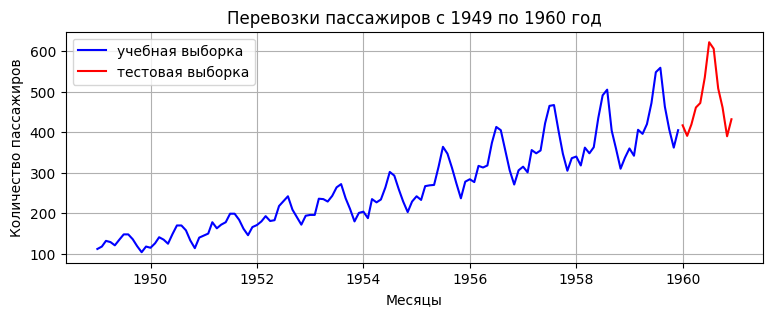

In [115]:
fig,ax = plt.subplots(figsize = (9,3))
ax.plot(train['#Passengers'], color = 'blue',label='учебная выборка')
ax.plot(test['#Passengers'], color = 'red',label='тестовая выборка')
ax.set_xlabel('Месяцы', )
ax.set_ylabel('Количество пассажиров',)
ax.set_title('Перевозки пассажиров с 1949 по 1960 год', )
ax.legend(title = '', loc = 'upper left', )
ax.grid()

In [116]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX


# # SARIMAX (p,d,q),(P,D,Q)

# model = SARIMAX(
#         train['bc'], 
#         order = (3, 0, 0),
#         seasonal_order = (0, 1, 0, 12)
#     ).fit(method='cg',full_output=False)

In [121]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


# SARIMAX (p,d,q),(P,D,Q)

model = SARIMAX(
        train['bc'], 
        order = (2, 0, 0),
        seasonal_order = (0, 1, 0, 12)
    ).fit(method='cg',full_output=False)

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


In [122]:
# мы можем посмотреть результат с помощью метода summary()
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                 bc   No. Observations:                  132
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 12)   Log Likelihood                 208.230
Date:                            Tue, 23 Apr 2024   AIC                           -410.460
Time:                                    18:13:26   BIC                           -402.098
Sample:                                01-01-1949   HQIC                          -407.064
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6694      0.069      9.647      0.000       0.533       0.805
ar.L2          0.3013      0.072   

# тестируем

In [123]:
start,end  = len(train), len(train)+len(test)-1
predicticted = inv_boxcox( model.predict(start, end), 0 )

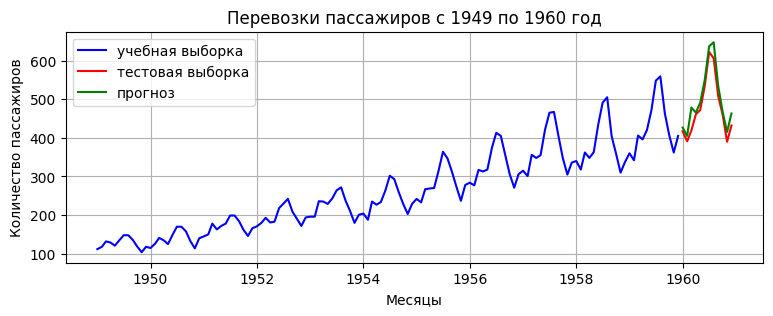

In [124]:
fig,ax = plt.subplots(figsize = (9,3))
ax.plot(train['#Passengers'], color = 'blue',label='учебная выборка')
ax.plot(test['#Passengers'], color = 'red',label='тестовая выборка')
ax.plot(predicticted, color = 'green',  label='прогноз')

ax.set_xlabel('Месяцы', )
ax.set_ylabel('Количество пассажиров',)
ax.set_title('Перевозки пассажиров с 1949 по 1960 год', )
ax.legend(title = '', loc = 'upper left', )
ax.grid()

---

In [125]:
# построим прогноз на три года вперед
start, end = len(train), (len(df)-1)+3*12
predicticted = inv_boxcox( model.predict(start, end), 0 )

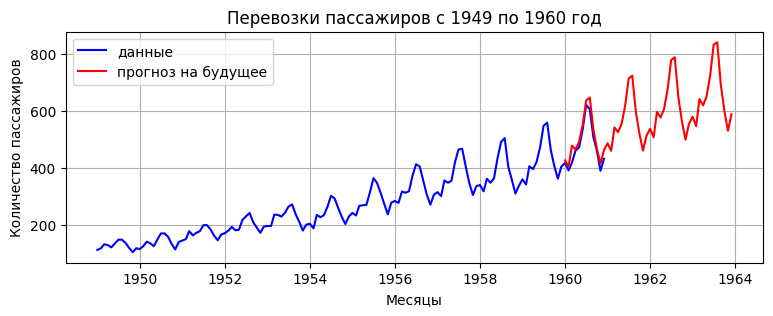

In [126]:
fig,ax = plt.subplots(figsize = (9,3))
ax.plot(df['#Passengers'], color = 'blue',label='данные')
ax.plot(predicticted, color = 'red',label='прогноз на будущее')
ax.set_xlabel('Месяцы', )
ax.set_ylabel('Количество пассажиров',)
ax.set_title('Перевозки пассажиров с 1949 по 1960 год', )
ax.legend(title = '', loc = 'upper left', )
ax.grid()